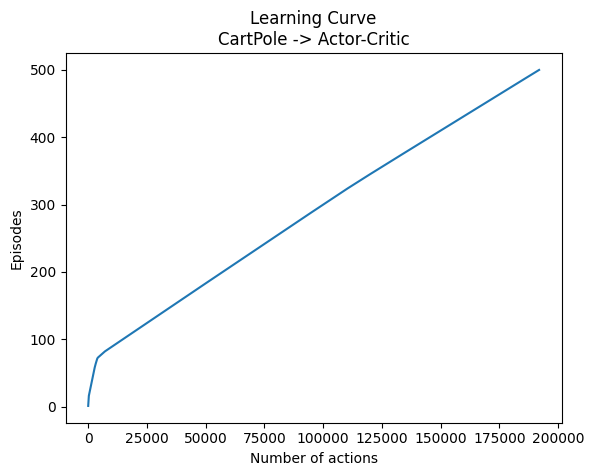

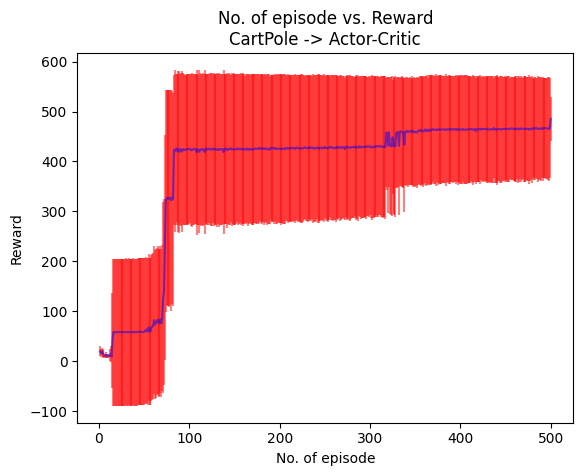

In [13]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import gym

def initialize_weights(order):
    k = 4 #need to change depending on state features when environment changes
    weight_count = (order + 1) ** k
    weights = np.zeros((weight_count,))
    return weights

def initialize_pweights(order, num_actions):
    k = 4 #need to change depending on state features when environment changes
    weight_count = (order + 1) ** k
    weights = np.zeros((num_actions, weight_count))
    return weights

def valuefunction_state(vweights, value_feature):  # need to initialize for value wts
    return np.dot(vweights, value_feature)

def policy(theta, norm_state):
    policy_list = []
    policy_features = fourier_function(order, norm_state)
    for i in range(2):  # need to change depending on actions in environment
        each_action_wt = theta[i]
        # print('each_action_wt', each_action_wt)

        each_action_phi = policy_features
        # print('each_action_phi', each_action_phi)

        each_action_value = np.dot(each_action_wt, each_action_phi)
        # print('each_action_value', each_action_value)

        policy_list.append(each_action_value)
    return policy_list

def normalize(state):
    x, v, omega, omega_dot = state

    norm = []
    n_x = (x + 4.8) / 9.6
    norm.append(n_x)
    n_v = (v + 4) / 8.0
    norm.append(n_v)
    n_omega = (omega + 0.418)/ 0.836
    norm.append(n_omega)
    n_omega_dot = (omega_dot + 2.5) / 5.0
    norm.append(n_omega_dot)

    return tuple(norm)

def select_action_softmax(policy, sigma):
    # policy is a list
    policy_arr = np.array(policy)

    # softMax

    numerator_values = [math.exp(sigma * x - max(sigma * policy_arr)) for x in policy_arr]

    # Calculate the denominator
    denominator_values = [math.exp(sigma * x - max(sigma * policy_arr)) for x in policy_arr]
    denominator = sum(denominator_values)

    # Calculate action probabilities
    action_probabilities = [numerator_value / denominator for numerator_value in numerator_values]

    selected_action = random.choices([0, 1], action_probabilities)[
        0]  # need to change depending on actions in environment

    selected_action_probability = action_probabilities[selected_action]

    return selected_action, selected_action_probability

def combination(order):  # need to change when environment changes
    combinations = []
    for x in range(order + 1):  # need to change when environment changes for state features since x,v,etc are specific
        for v in range(order + 1):
            for omega in range(order + 1):
                for omega_dot in range(order + 1):
                    combinations.append([x, v, omega, omega_dot])
    return combinations


def fourier_function(order, normalized_state):
    fourier_count = (order + 1) ** len(normalized_state)  # need to change when environment changes
    fourier_features = np.zeros((fourier_count,))

    combinations_list = combination(order)

    for j in range(fourier_count):
        c_j = combinations_list[j]

        exponent = np.dot(np.array(normalized_state),
                          c_j)  # no need to transpose since state features are taken as tuples
        fourier_features[j] = np.cos(np.pi * exponent)

    return fourier_features

def runEpisode(theta, w, policy_alpha, v_alpha, sigma):
    env = gym.make('CartPole-v1')
    
    state = env.reset()[0]
    end = False
    reward_episode = 0
    capital_i = 1
    
    for _ in range(500): #timesteps
        
        if end or reward_episode == 500: # terminal state
            break
            
        reward_episode += 1
        norm_state = normalize(state)
        
        policy_vector = policy(theta, norm_state)
        action_taken, action_prob = select_action_softmax(policy_vector, sigma)
        
        next_state, reward, end, truncated, info = env.step(action_taken)

        norm_next_state = normalize(next_state)

        
        value_feature_nextstate = fourier_function(order, norm_next_state)
        value_feature_state = fourier_function(order, norm_state)
        delta = reward + (discount * valuefunction_state(w, value_feature_nextstate)) - \
                  valuefunction_state(w, value_feature_state)
        
        w += float(v_alpha * delta) * \
            fourier_function(order, norm_state)

        derviative = [1 - action_prob if i == action_taken else -1 * action_prob for i in range(2)] #need to change i == action_taken for another environment
        for i in range(2): # need to change when environment changes
            theta[i] += float(policy_alpha * delta * capital_i) * \
                derviative[i] * \
                fourier_function(order, norm_state)

        capital_i *= discount
        state = next_state

    return theta, w, reward_episode

run_algo_times = 2
num_episodes = 500
alpha = 0.01
sigma = 1 #exploration
order = 1
discount = 1


reward_list = []
action_list = []
for i in range(run_algo_times):
    run_reward = []
    start_action = [0]*(num_episodes+1)
    theta = initialize_pweights(order, 2) # need to change when environment changes
    w = initialize_weights(order)
    p_alpha = alpha
    v_alpha = alpha
    for i in range(num_episodes):
        pweights, vweights, epi_rewards = runEpisode(
            theta, w, p_alpha, v_alpha, sigma)
        run_reward.append(epi_rewards)
        start_action[i+1] = start_action[i] + epi_rewards
    reward_list.append(run_reward)
    action_list.append(start_action)
    
avg_reward = np.mean(np.array(reward_list), axis=0)
std_reward = np.std(np.array(reward_list), axis=0)
avg_action_list = np.mean(action_list, axis=0)

episoderange = range(1, num_episodes+1)

plt.plot(avg_action_list[1:], episoderange)
plt.title('Learning Curve\nCartPole -> Actor-Critic')
plt.xlabel('Number of actions')
plt.ylabel('Episodes')
plt.show()


plt.errorbar(episoderange, avg_reward, yerr=std_reward, color='blue', ecolor='red', alpha = 0.5)
plt.title('No. of episode vs. Reward\nCartPole -> Actor-Critic')
plt.xlabel('No. of episode')
plt.ylabel('Reward')
plt.show()


In [4]:
print('Learning Curve\nCartPole -> Actor-Critic')

Learning Curve
CartPole -> Actor-Critic
